In [53]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [54]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [55]:
Carseats = load_data("Carseats")
High = np.where(Carseats.Sales > 8, "Yes", "No")

In [56]:
model = MS(Carseats.columns.drop("Sales"), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

In [57]:
clf = DTC(criterion="entropy", max_depth=3, random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [58]:
accuracy_score(High, clf.predict(X))

0.79

In [59]:
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

np.float64(0.4710647062649358)

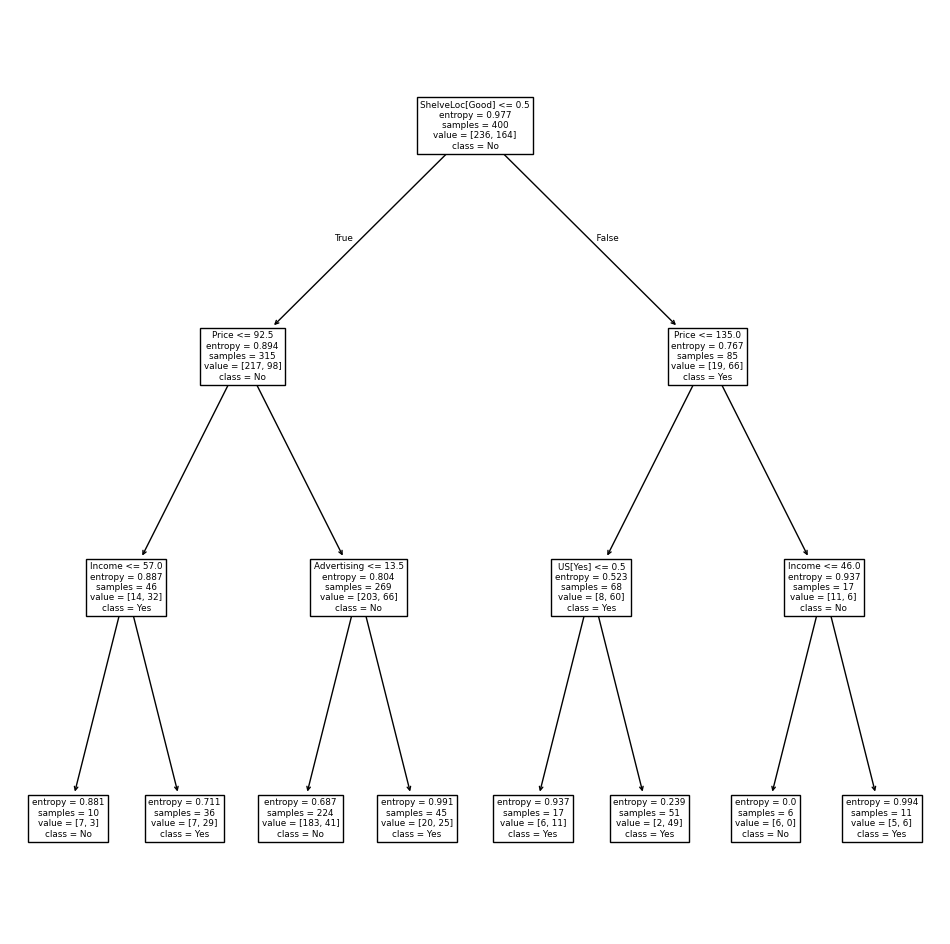

In [60]:
ax = subplots(figsize=(12, 12))[1]
plot_tree(clf, feature_names=feature_names, class_names=["No", "Yes"], ax=ax);

In [61]:
validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(clf, D, High, cv=validation)
results["test_score"]

array([0.685])

In [62]:
(X_train, X_test, High_train, High_test) = skm.train_test_split(X, High, test_size=0.5, random_state=0)

In [63]:
clf = DTC(criterion="entropy", random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

In [64]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)

In [65]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

np.float64(0.685)

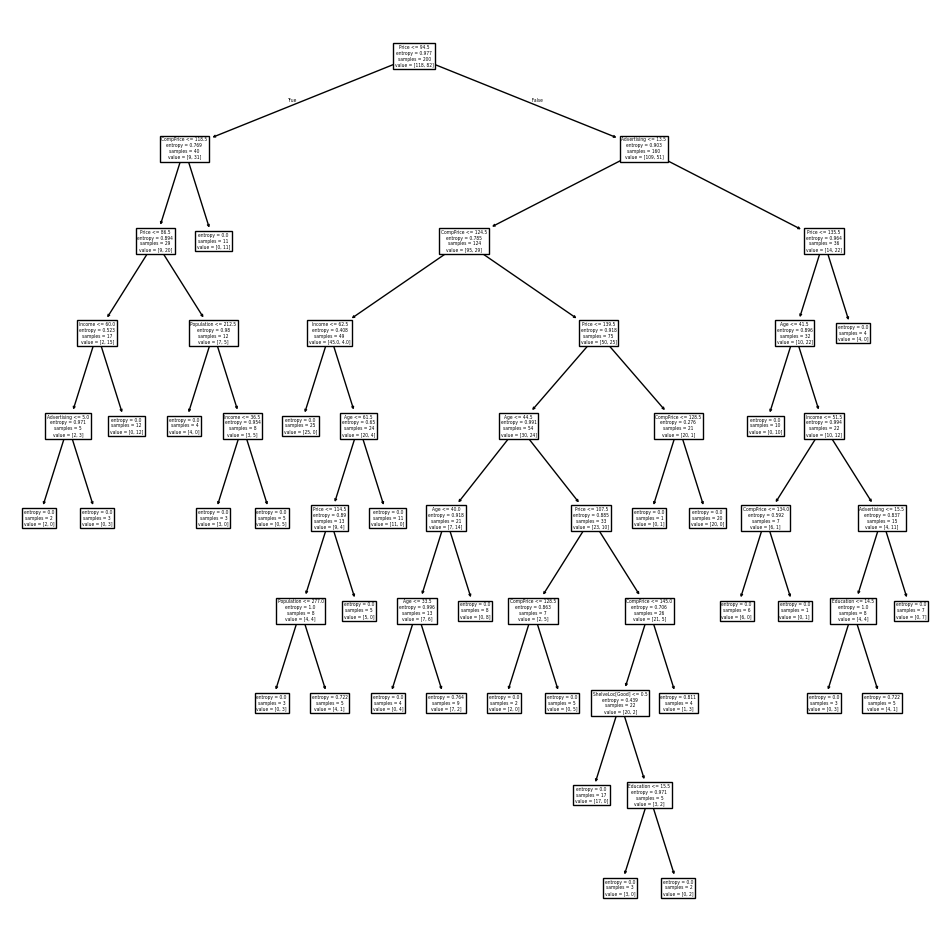

In [66]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

In [67]:
best_.tree_.n_leaves

np.int64(30)

In [68]:
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion

0.72


Truth,No,Yes
Predicted,,
No,94,32
Yes,24,50


In [69]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop("medv"), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [70]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, Boston["medv"], test_size=0.3, random_state=0)

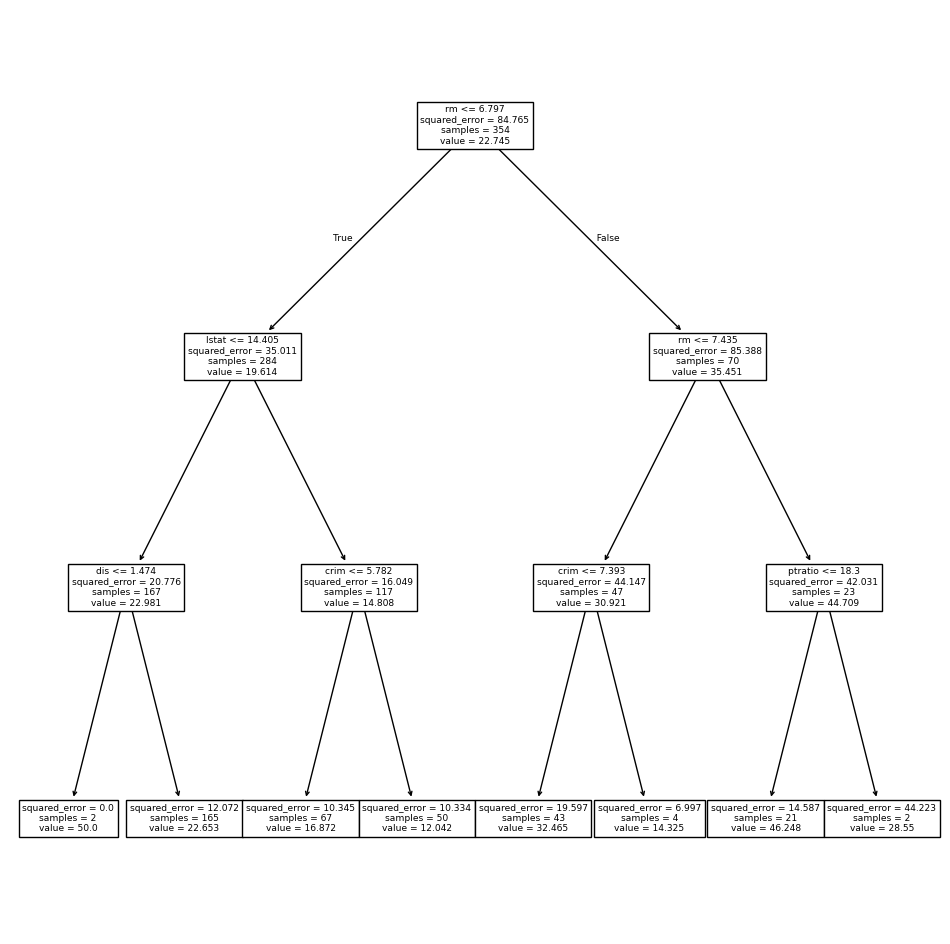

In [71]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12, 12))[1]
plot_tree(reg, feature_names = feature_names, ax=ax);

In [72]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [73]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

np.float64(28.06985754975404)

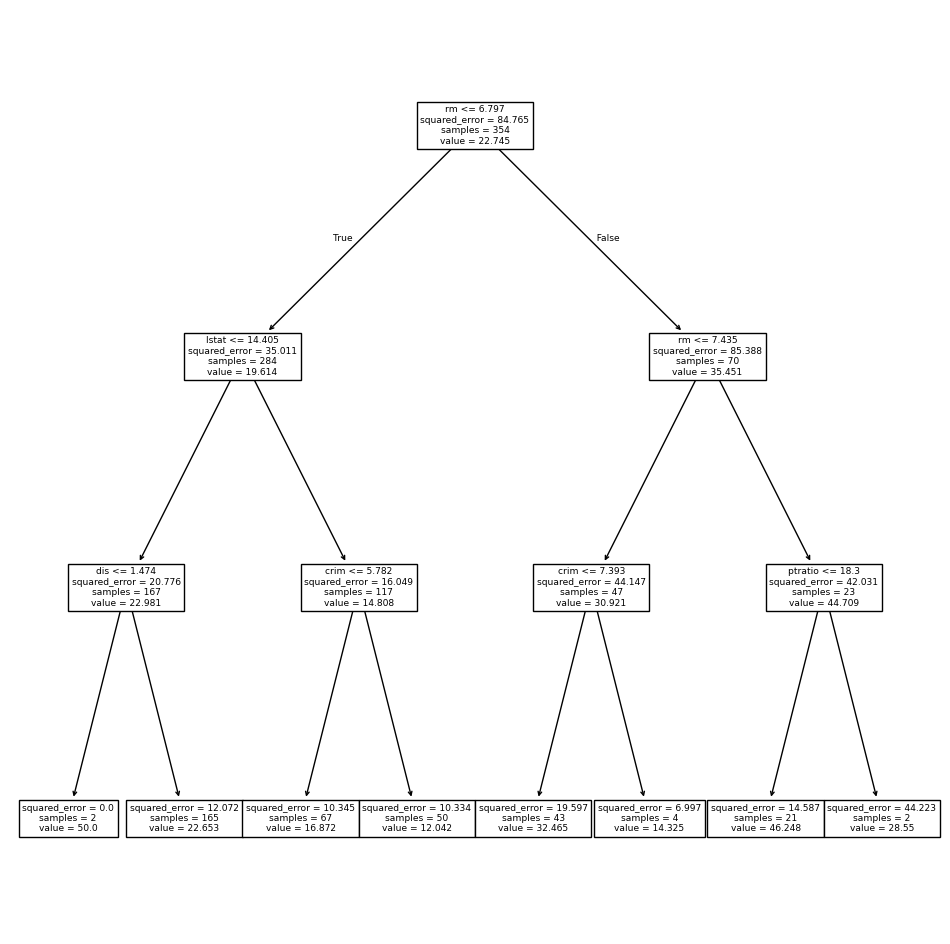

In [74]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

In [75]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

np.float64(14.634700151315787)

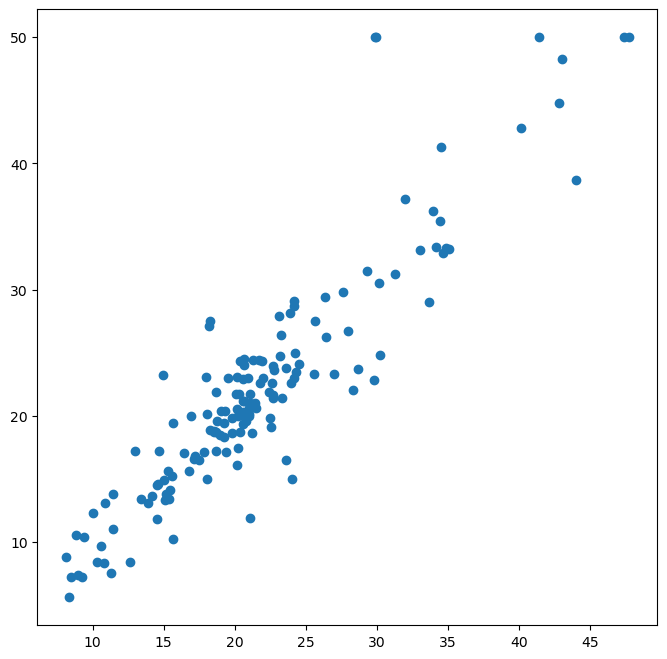

In [76]:
ax = subplots(figsize=(8, 8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)

In [77]:
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

np.float64(14.605662565263161)

In [78]:
RF_boston = RF(max_features=6, random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

np.float64(20.04276446710527)

In [79]:
feature_imp = pd.DataFrame(
    {'importance':RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


In [84]:
boost_boston = GBR(n_estimators=5000, learning_rate=0.001, max_depth=3, random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

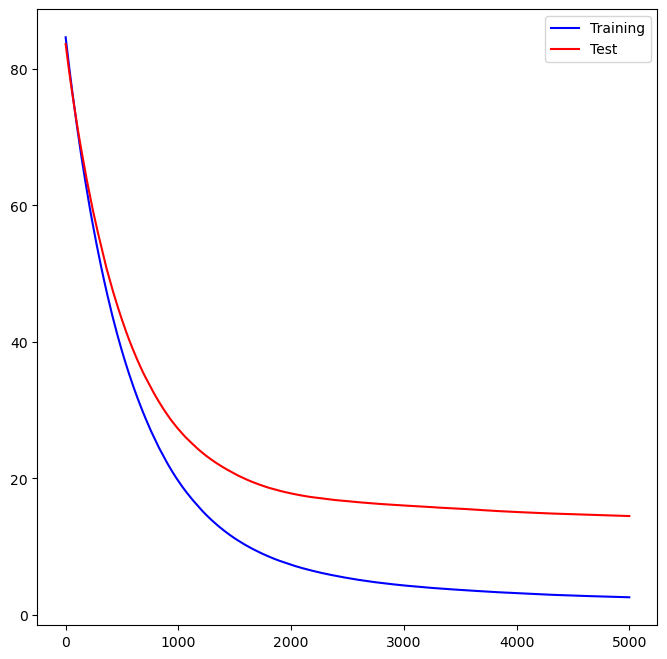

In [85]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [86]:
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)


np.float64(14.481405918831591)